In [1]:
import pandas as pd
%pylab inline
from hmmlearn import hmm

Populating the interactive namespace from numpy and matplotlib


In [2]:
path_to_file5sec = "/media/sf_VBox_Shared/London/accelerometer_5second/merged/__016563_2014-08-08 12-02-19.bin_day1.csv"
day1_5sec = pd.read_csv(path_to_file5sec)

In [3]:
day1_5sec = day1_5sec.set_index('timestamp')
day1_5sec.index = pd.to_datetime(day1_5sec.index)
print(min(day1_5sec.index))
print(max(day1_5sec.index))
day1_5sec.head()

2014-08-01 04:00:00
2014-08-02 03:59:55


,acceleration,anglex,angley,anglez,invalid,Activity
timestamp,,,,,,
2014-08-01 04:00:00,0.014778,27.403869,39.648207,-38.117174,0,NaN
2014-08-01 04:00:05,0.014978,27.407743,39.603882,-38.158723,0,Sleepingandresting(includingsickinbed)
2014-08-01 04:00:10,0.013872,27.428900,39.538962,-38.206537,0,Sleepingandresting(includingsickinbed)
2014-08-01 04:00:15,0.015469,27.417167,39.553611,-38.201570,0,Sleepingandresting(includingsickinbed)
2014-08-01 04:00:20,0.014622,27.420342,39.680349,-38.070763,0,Sleepingandresting(includingsickinbed)


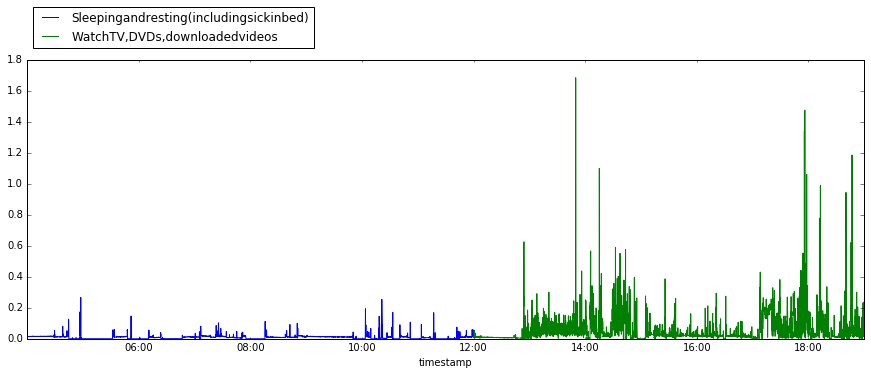

In [4]:
byAct = day1_5sec.groupby('Activity')
fig, ax = plt.subplots(figsize=(15,5))
for act,dfa in byAct:
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);

In [5]:
day1_5sec.groupby('Activity').count()

,acceleration,anglex,angley,anglez,invalid
Activity,,,,,
Sleepingandresting(includingsickinbed),5759,5759,5759,5759,5759
"WatchTV,DVDs,downloadedvideos",5039,5039,5039,5039,5039


In [6]:
X = np.column_stack([day1_5sec.acceleration, day1_5sec.anglex, day1_5sec.angley, day1_5sec.anglez])
column_names = day1_5sec.columns[0:4]
print(column_names)

Index(['acceleration', 'anglex', 'angley', 'anglez'], dtype='object')


In [7]:
#Parameters for HMM
nr_states = 2
transmat_prior = np.ones((nr_states, nr_states))
transmat_prior[np.diag_indices(nr_states)] = 99
print(transmat_prior)
transmat_prior /= np.sum(transmat_prior, axis=0)
print(transmat_prior)

[[ 99.   1.]
 [  1.  99.]]
[[ 0.99  0.01]
 [ 0.01  0.99]]


In [8]:
model = hmm.GaussianHMM(n_components=nr_states, covariance_type="diag", n_iter=1000).fit(X)

In [9]:
hidden_states = model.predict(X)

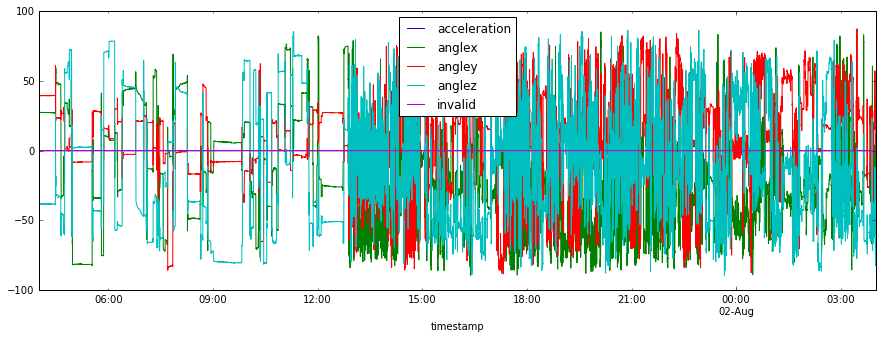

In [10]:
day1_5sec.plot(figsize=(15,5))
plt.show()

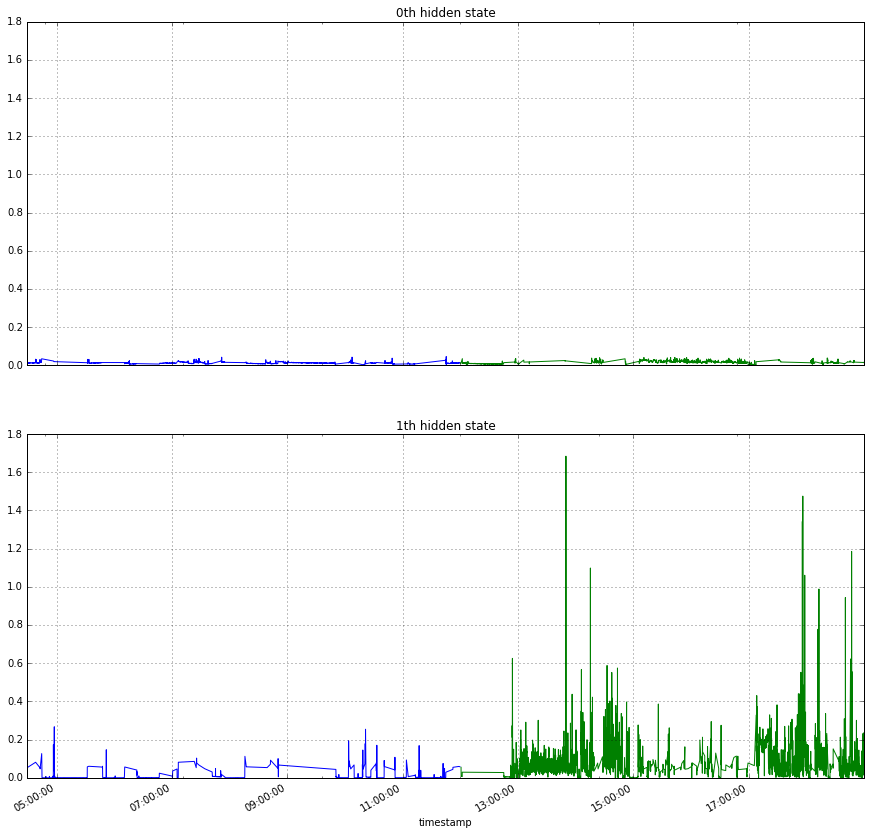

In [12]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    byAct = day1_5sec[mask].groupby('Activity')
    for act,dfa in byAct:
        dfa['acceleration'].plot(ax=ax, label=act)
    #ax.plot(plotdata, ".-")
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    #ax.xaxis.set_major_locator(YearLocator())
    #ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

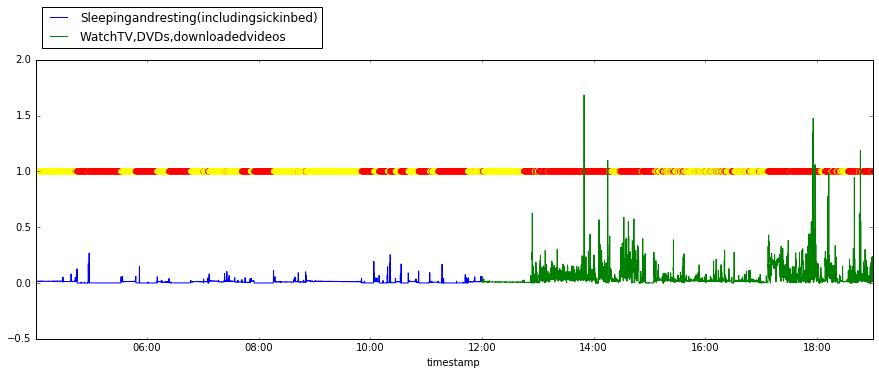

In [13]:
fig = figure(figsize=(15,5))
byAct = day1_5sec.groupby('Activity')
fig, ax = plt.subplots(figsize=(15,5))
for act,dfa in byAct:
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);
colormap = {0: (1,1,0), 1: (1,0,0), 2: (0,1,0), 3: (0,0,1)}
state_colors = [colormap[i] for i in hidden_states]
plt.scatter(day1_5sec.index, np.ones_like(hidden_states), color=state_colors)
#plt.xlim(min(), max(byAct.index))

In [138]:
model.transmat_

array([[ 0.95741117,  0.04258883],
       [ 0.03704744,  0.96295256]])

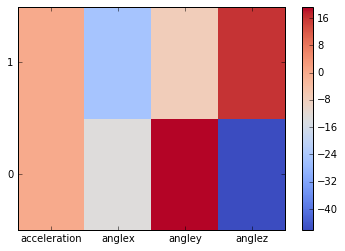

In [139]:
plotdata = model.means_

fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(range(plotdata.shape[0]), minor=False)
plt.colorbar(colorplot)

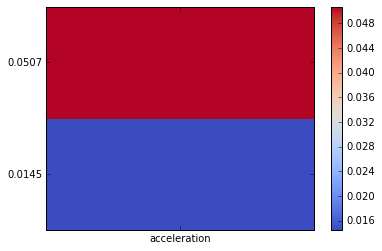

In [140]:
plotdata = model.means_[:,0][:,np.newaxis]
grouplabels = ["{:.3}".format(x) for x in plotdata[:,0]]
fig, ax = plt.subplots()
colorplot = ax.pcolor(plotdata, cmap='coolwarm',)
ax.set_xticks(np.arange(plotdata.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(plotdata.shape[0])+0.5, minor=False)
ax.set_xticklabels(column_names, minor=False)
ax.set_yticklabels(grouplabels, minor=False)
fig.colorbar(colorplot)
print()

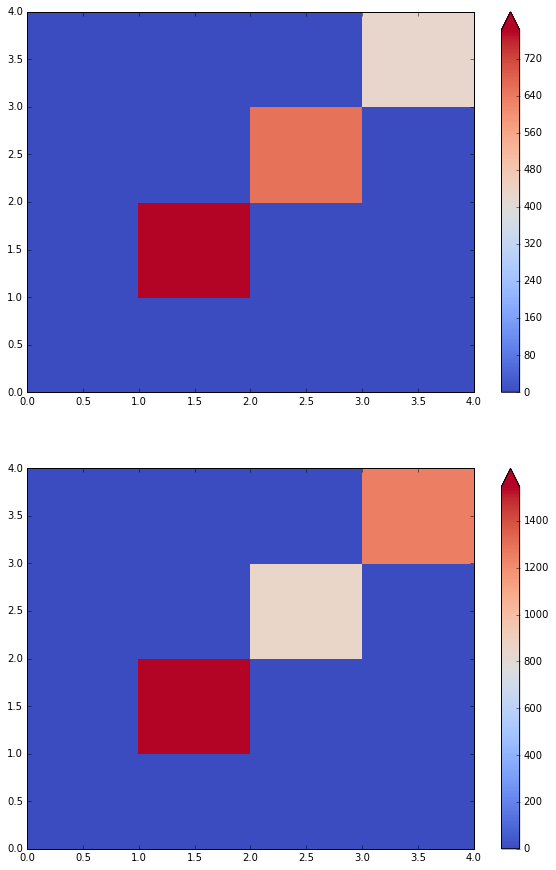

In [141]:
fig, axs = plt.subplots(nrows=model.n_components, ncols=1,  figsize = (10, 15))
for i in range(nr_states):
    im = axs[i].pcolor(model.covars_[i], cmap='coolwarm',)
    fig.colorbar(im, ax = axs[i], extend='max')
#colorbar()
show()

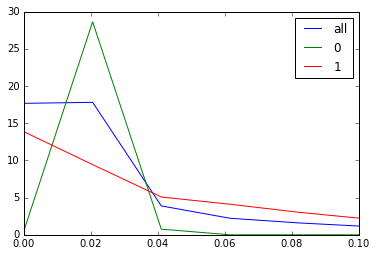

In [142]:
from scipy.stats.kde import gaussian_kde

variable = "acceleration"

fig, ax = subplots()
#day1_5sec.hist(variable, bins=100)
vals = day1_5sec[variable]
kde = gaussian_kde(vals)
d = np.linspace(min(vals), max(vals), 100)
p = plot(d, kde(d), label="all")

for i in range(nr_states):
    mask = hidden_states == i
    kde = gaussian_kde(vals[mask])
    plot(d, kde(d), label=str(i))
    #p = plt.hist(day1_5sec[mask][variable], bins=100)
ax.set_xlim(0,0.1)
legend()
show()

In [143]:
column_names

Index(['acceleration', 'anglex', 'angley', 'anglez'], dtype='object')